In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from model import Generator, Discriminator
from torchvision.utils import save_image
from tqdm import tqdm
import os



In [2]:
dataroot = "data/"
save_path = "checkpoints" 
image_save_path = os.path.join(save_path, 'images')
weights_save_path = os.path.join(save_path, 'weights')
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(weights_save_path, exist_ok=True) 
image_size = 96  
batch_size = 128
workers = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
dataset = ImageFolder(root=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,drop_last=True)

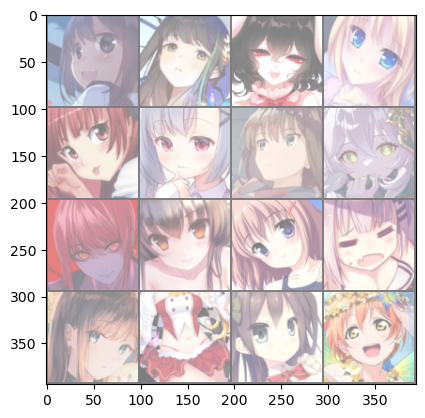

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, _ = next(dataiter)
grid_img = vutils.make_grid(images[:16], nrow=4, padding=2, normalize=True) # 调整nrow值，以适应您的显示
imshow(grid_img)

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)

# G.load_state_dict(torch.load(f'{weights_save_path}/G_epoch_5.pth'))
# D.load_state_dict(torch.load(f'{weights_save_path}/D_epoch_5.pth'))

In [7]:
lr = 0.0002
beta1 = 0.5
G_opt = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_opt = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = torch.nn.BCELoss().to(device)
fix_noise = torch.randn(batch_size, 100, 1, 1).to(device)
true_label = torch.ones(batch_size).to(device)

false_label = torch.zeros(batch_size).to(device)
epochs = 200
G_losses = []
D_losses = []

In [8]:
for epoch in range(epochs):
    G_loss_accum = 0.0
    D_loss_accum = 0.0
    num_batches = 0

    for batch_index, (img,_) in enumerate(tqdm(dataloader,total=len(dataloader))):
        noise = torch.randn(batch_size, 100, 1, 1).to(device)
        img = img.to(device)
        # Train Discriminator
        D_opt.zero_grad()

        true = D(img)
        fake_img = G(noise)
        fake = D(fake_img)

        D_loss_t = criterion(true, true_label)
        D_loss_t.backward()

        D_loss_f = criterion(fake, false_label)
        D_loss_f.backward()
        D_opt.step()

        D_loss_accum += D_loss_t.item() + D_loss_f.item()

        # Train Generator
        G_opt.zero_grad()
        fake_img = G(noise)
        fake = D(fake_img)
        G_loss = criterion(fake, true_label)
        G_loss.backward()
        G_opt.step()

        G_loss_accum += G_loss.item()
        num_batches += 1


    if epoch % 5 == 0:
        with torch.no_grad():
            fake_img = G(fix_noise).detach().cpu()
        img_grid = vutils.make_grid(fake_img, nrow=8, padding=2, normalize=True)
        vutils.save_image(img_grid, f'{image_save_path}/fake_epoch_{epoch}.jpg')

        torch.save(G.state_dict(), f'{weights_save_path}/G_epoch_{epoch}.pth')
        torch.save(D.state_dict(), f'{weights_save_path}/D_epoch_{epoch}.pth')

    print(f"Epoch {epoch}: G_loss = {G_loss_accum / num_batches:.4f}, D_loss = {D_loss_accum / num_batches:.4f}", end='\r')
    G_losses.append(G_loss_accum / num_batches)
    D_losses.append(D_loss_accum / num_batches)

# Plot the losses
plt.plot(G_losses, label='Generator loss')
plt.plot(D_losses, label='Discriminator loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_plot.png')


100%|██████████| 416/416 [10:54<00:00,  1.57s/it]


100%|██████████| 416/416 [12:03<00:00,  1.74s/it]


100%|██████████| 416/416 [19:27<00:00,  2.81s/it]


  3%|▎         | 14/416 [00:39<19:05,  2.85s/it] 


KeyboardInterrupt: 